In [18]:
from CATCH.Localizer import Localizer
from CATCH.Estimator import Estimator
from CATCH.CATCHobject import CATCH, crop_frame
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

## Using CATCH ##

This notebook will show you how to use the built-in default models to detect, localize, and estimate parameters of particles from normalized holographic images. These models are applicable for use on particles dispersed in water ($n_m = 1.34$), imaged with blue light ($\lambda = 0.447 \mu m$) with a magnification of $0.048 \mu m$ per pixel.


First, we will upload an example hologram that we wish to analyze.

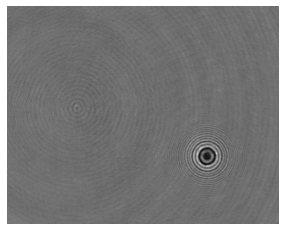

In [10]:
holo = cv2.imread('../examples/test_image_large.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(holo, cmap='gray')
plt.axis('off')
plt.show()

We can extract all of this information from this image in only a few lines of code. We first initialize the model, then send the hologram into the model as input, and the outputs are formatted as a pandas Dataframe. Each row corresponds to one detected particle.

In [12]:
catch = CATCH()
results = catch.analyze([holo])
print(results)

Adding autoShape... 
  label      conf         x_p         y_p                    bbox   edge  \
0  holo  0.923928  941.817627  706.793091  ((790, 556), 301, 300)  False   
1  holo  0.885009  331.602875  478.746521  ((152, 300), 358, 356)  False   

   framenum         z_p       a_p       n_p  
0         0  150.382812  0.861771  1.665479  
1         0  216.996750  0.263039  1.475267  


#### Let's go through each column in this dataframe and explain what they mean: ####

*label* : the name or class of the detected particle. In the default model, all particles are labeled "holo"

*conf* : the confidence with which the detection algorithm has correctly idenfitied this particle, with the correct class

*x_p* : the predicted x-position of the center of the particle, expressed in pixels. Conversion to real units can be performed with knowledge of the magnification factor.

*y_p* : the predicted y-position of the center of the particle, expressed in pixels.

*bbox* : the bounding box of the region of interest, formatted like: ((x1,y1),w,h) where (x1,y1) is the position of the top left corner of the box, and w,h are the width and height of the box. These values are expressed in pixels.

*edge* : a boolean factor that determines whether the entire bounding box fits in the field of view. If edge=True, estimator predictions may be less accurate.

*framenum* : the index of the frame in which the particle appears. Useful for analyzing a sequence of frames all at once.

*z_p* : the predicted axial position (z) of the center of the particle, expressed in pixels.

*a_p* : the predicted radius of the particle, expressed in microns.

*n_p* : the predicted refractive index of the particle.

Suppose, however, that we're interested in the intermediate steps of this end-to-end process. For example, perhaps we only need detection and localization predictions for in-plane particle tracking. We can run this image only through the first module. 

Adding autoShape... 
Feature at (941.8, 706.8) with 0.92 confidence
Feature at (331.6, 478.7) with 0.89 confidence


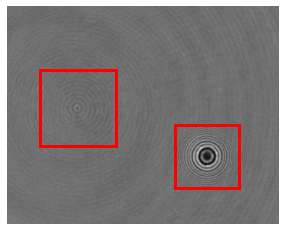

In [17]:
loc = Localizer()

features = loc.detect([holo])[0]

style = dict(fill=False, linewidth=3, edgecolor='r')
report = 'Feature at ({0:.1f}, {1:.1f}) with {2:.2f} confidence'

fig, ax = plt.subplots()
ax.imshow(holo, cmap='gray')
ax.axis('off')
for feature in features:
    corner, w, h = feature['bbox']
    ax.add_patch(Rectangle(xy=corner, width=w, height=h, **style))
    print(report.format(feature['x_p'], feature['y_p'], feature['conf']))
plt.show()

The CATCH module contains a built-in function which can crop the associated pixels obtained from the localization predictions.

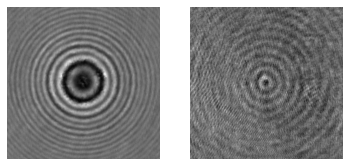

In [23]:
crops = crop_frame(holo, features)

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(crops[0], cmap='gray')
ax1.axis('off')
ax2.imshow(crops[1], cmap='gray')
ax2.axis('off')
plt.show()

We can send these crops into the estimation module to obtain predictions for axial position, radius, and refractive index. These modules can handle multiple inputs at once.

In [24]:
est = Estimator()

est.predict(crops)

[{'z_p': 150.3828125, 'a_p': 0.8617712259292603, 'n_p': 1.6654791831970215},
 {'z_p': 216.9967498779297,
  'a_p': 0.2630390524864197,
  'n_p': 1.4752674102783203}]

From here, you may be interested in refining these parameter estimates using the generative model for Lorenz-Mie theory. This fit can be performed using the pylorenzmie package (or your favorite holography module).

In [34]:
from pylorenzmie.analysis import Feature
from pylorenzmie.theory import LMHologram
from pylorenzmie.utilities import coordinates
from pylorenzmie.utilities.visualization import report

#initialize feature object
f = Feature(model=LMHologram(double_precision=False))
    
# Instrument configuration
ins = f.model.instrument
ins.wavelength = 0.447     # [um]
ins.magnification = 0.048  # [um/pixel]
ins.n_m = 1.34

#load normalized hologram into feature's data
f.data = crops[0]/np.mean(crops[0])
f.coordinates = coordinates(crops[0].shape, corner=results.iloc[0].bbox[0])

#load ML predictions into particle parameters as initial estimates
p = f.particle
p.properties = results.iloc[0]

npixels = 9060
x_p = 938.98 +- 0.02 [pixels]
y_p = 704.26 +- 0.02 [pixels]
z_p = 159.34 +- 0.09 [pixels]
a_p = 1.070 +- 0.001 [um]
n_p = 1.5391 +- 0.0004
chisq = 3.28


Text(0.5, 1.0, 'Residuals')

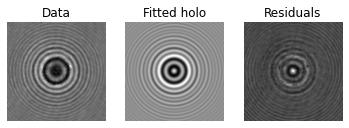

In [43]:
#optimize
refined = f.optimize()
report(refined)

#plot results
fig, axes = plt.subplots(1,3)
for ax in axes:
    ax.axis('off')
axes[0].imshow(f.data, cmap='gray')
axes[0].set_title('Data')
axes[1].imshow(f.hologram(), cmap='gray')
axes[1].set_title('Fitted holo')
axes[2].imshow(f.residuals()+1, cmap='gray')
axes[2].set_title('Residuals')